In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats as st
import datetime as dt

In [2]:
pd.set_option('display.max_colwidth', None)

# Тема: Анализ А/В теста по увеличению выручки интернет-магазина

## Предобработка данных

Прочитаем файлы и сохраним в переменную:

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv') 

orders = pd.read_csv('/datasets/orders.csv')

visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
frame = {"hypothesis_frame":hypothesis,
         "orders_frame":orders,
         "visitors_frame":visitors
        }  #создадим словарь для того, чтобы можно было по нему пробежаться

for name, information in frame.items():
    print('\033[1m' + name.upper() + '\033[0m')
    display(
        information.head(),   #открываем фрейм
        information.info(), #выводим информацию о фрейме
        information.isna().sum(), #посмотрим на пропуски
        information.duplicated().sum() #выведем явные дубликаты для изучения
    ) 
    

HYPOTHESIS_FRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


None

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

0

ORDERS_FRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


None

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

0

VISITORS_FRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


None

date        0
group       0
visitors    0
dtype: int64

0

Итак, в таблице `hypothesis` пять столбцов. 

Согласно документации к данным:

* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

В таблице `orders` пять столбцов:

* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

В таблице  `visitors` три столбца:

* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

   

Изучив данные приходим к выводу, что нужно сделать следущие действия для корректной работы с данными:

1) Привести к нижнему регистру названия столбцов в таблице hypothesis.

2) Привести к змеиному регистру название столбцов в таблице orders.

3) Привести дату к формату datatime в таблицах orders и visitors.

In [5]:
hypothesis.columns = hypothesis.columns.str.lower() #для удобства привидем название столбцов к нижнему регистру


orders = orders.rename(columns={'transactionId': 'transaction_id',
                                'visitorId': 'visitor_id'})  #змеиный регистр

#orders['date'] = orders['date'].map(
#    lambda x: dt.datetime.strptime(x, '%Y-%m-%d') #приводим формат к datatime
#)

orders['date'] = pd.to_datetime(orders['date'])

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d') #приводим формат к datatime
)


## Приоритизация гипотез. 

**Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.**

In [6]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'] #посчитаем ICE Score
hypothesis_ice = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)
hypothesis_ice # выведим фрейм с приоритизацией ICE


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По показателю ICE в приоритете топ-3 следующих гипотез:

1) Запустить акцию, дающую скидку на товар в день рождения	

2) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

3) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

**Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.**

In [7]:
hypothesis['RICE'] = (
    hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'] #посчитаем ICE Score

hypothesis_rice = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
hypothesis_rice # выведим фрейм с приоритизацией RICE 


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По показателю RICE в приоритете топ-3 следующих гипотез:

1) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	

3) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Укажим, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.**

Смержируем две таблицы и посмотрим на результат:

In [8]:
priority = hypothesis_ice.merge(hypothesis_rice, on = 'hypothesis', how = 'left')
priority

,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


Основное отличие приотритизации между методами ICE и RICE заключается в том, что метод RICE учитывает количество пользователей, которых затронет изменение, в связи с этим многии значения значительно отличаются. Например, самая большое отличие в показателях гипотезы `"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"`, так как это изменение касается всех пользователей поэтому значение reach - 10 и логично, что RICH значительно увеличивается.

Самое минимальная отличие в показателях гипотезы `"Запустить акцию, дающую скидку на товар в день рождения"`. Так как этот изменение в интервале теста каснется не так много пльзователей, то соответсвенно reach - 1 и влияние на показатель RICE минимальное.

##  Анализ A/B-теста

Cоздаем массив уникальных пар значений дат и групп теста:

### Построим график кумулятивной выручки по группам. 

In [9]:
datesGroups = (orders[['date','group']]
               .drop_duplicates()
               .sort_values(by='date')
              )

Соберём агрегированные кумулятивные по дням данные о заказах:

In [10]:
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                           .agg({'date' : 'max', 
                                 'group' : 'max', 
                                 'transaction_id' : 'nunique', 
                                 'visitor_id' : 'nunique', 
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

Соберём агрегированные кумулятивные по дням данные  о посетителях интернет-магазина:

In [11]:
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 
                                   'group' : 'max', 
                                   'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )

Объединим обе таблицы в одну:

In [12]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

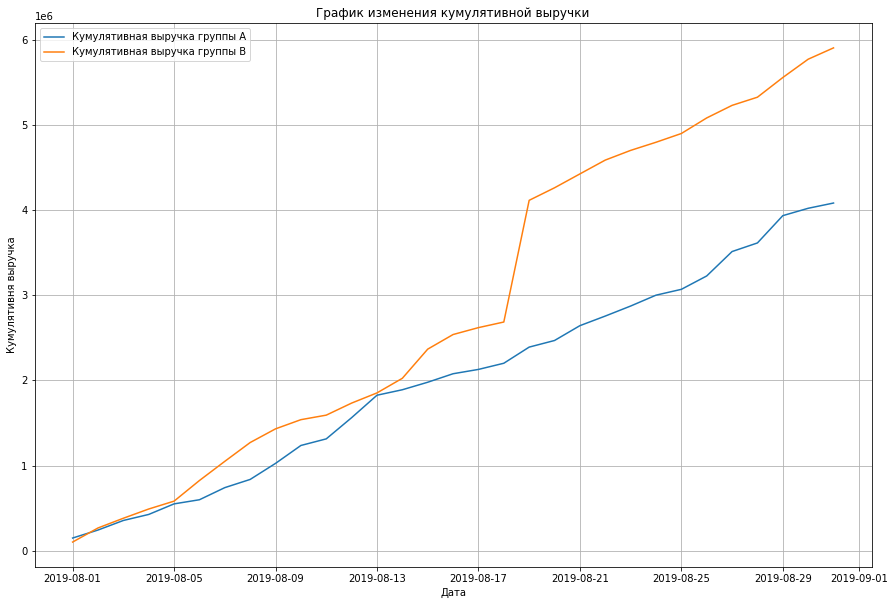

In [13]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]




#СТРОИМ ГРАФИК

plt.figure(figsize=(15,10))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кумулятивная выручка группы A') 

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кумулятивная выручка группы B') 




plt.title('График изменения кумулятивной выручки')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивня выручка')
plt.grid()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. От начала теста 2019-08-01 видно, что в группе "B" выручка растет быстрее, чем в группе "А". Однако в группе "B"  2019-08-19 наблюдается резкое увеличение кумулятивной выручки, что может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

Оценим стоимость заказов:

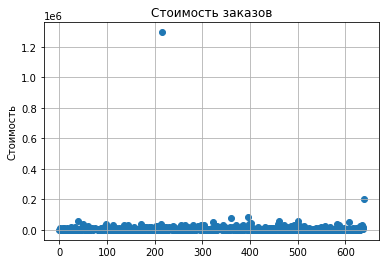

In [14]:
y_values = orders[orders['group'] == 'B'] #выделим заказы группы "B"
x_values = pd.Series(range(0,len(y_values['revenue'])))

                  
plt.scatter(x_values,y_values['revenue']) 

plt.title('Стоимость заказов')
plt.ylabel('Стоимость')
plt.grid()
plt.show()

In [15]:
median_b = y_values['revenue'].median()
mean_b = y_values['revenue'].mean()
display(f'Средняя стоимость заказов в группе "B" равен {mean_b}, медианная стоимость заказа равнов {median_b}')

'Средняя стоимость заказов в группе "B" равен 9230.875, медианная стоимость заказа равнов 2965.0'

Итак, видно, что есть явно выбивающие стоимости заказа. Скорее всего даже 2. Заказ больше 1,2миллиона рублей и заказ ~ 200 000 тысяч. Более подробно выбросы рассмотрим ниже.

### Построим график кумулятивного среднего чека по группам.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

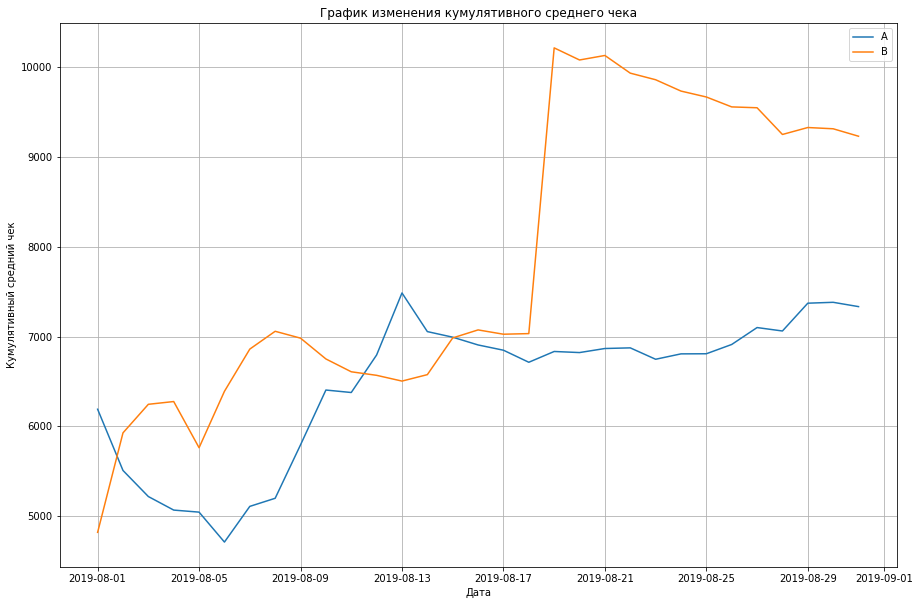

In [16]:
plt.figure(figsize=(15,10))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График изменения кумулятивного среднего чека')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.grid()

Можно заметить, что на кумулятивный средний чек так же влияет выброс, что не удивительно. Коммуллитивный средний чек группы "B" больше почти на всем интервале теста. Однако, в интервале с 1 по 2 августа и с 12 по 15 августа комулятивный средний чек группы "А" больше чем группы "В". После 13 августа комулятивный средний чек группы "А" притерпивает стагнацию показателя.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

Построим график относительного различия для среднего чека:

In [17]:
# объединим таблицы cumulativeRevenueA и cumulativeRevenueB

mergedCumulativeRevenue = (cumulativeRevenueA
                           .merge(cumulativeRevenueB, 
                                  left_on='date', 
                                  right_on='date', 
                                  how='left', 
                                  suffixes=['A', 'B'])
                          )

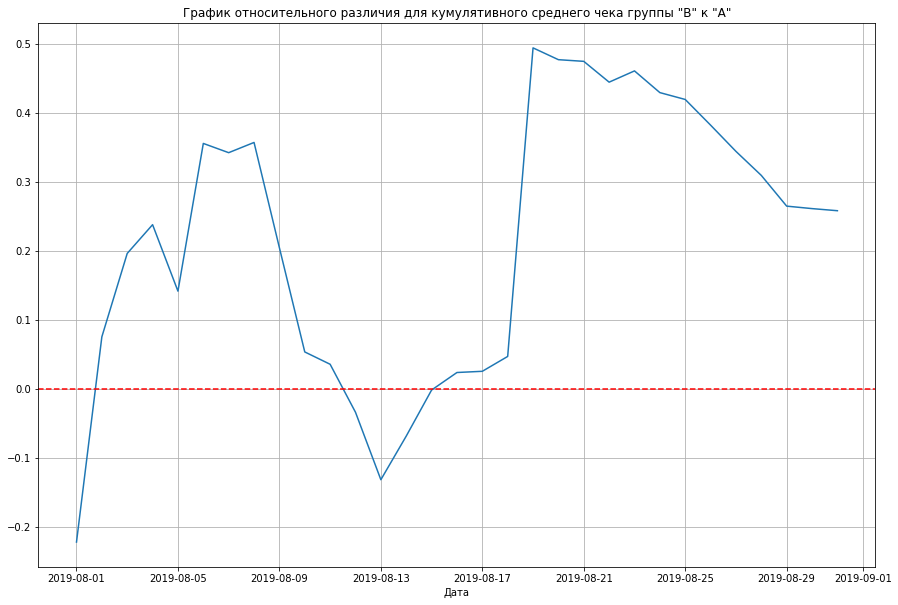

In [18]:
plt.figure(figsize=(15,10))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--') 


plt.title('График относительного различия для кумулятивного среднего чека группы "В" к "А"')
plt.xlabel('Дата')
plt.grid()

Выводы по этому графику будут аналогичны графику кумулятивного среднего чека. Куммулятивный средний чек группы "В" рос с начала теста 01.08.2019 по 07.08.2019. Затем с 07.08.2019 происходит уменьшение кумулятивного чека группы "В", снижение идет вплоть до 13.08.2019. Наблюдательно, что в интервале 12.08.2019...15.08.2019 средний сек группы "В" ниже группы "А". Начиная с  15.08.2019 средний чек группы "В" снова становиться больше среднего чека группы "А". На графике 19 августа, так же наблюдается выброс, который мы определили ранее.

### Построим график кумулятивной конверсии по группам

Добавим в cumulativeData столбец 'conversion' c отношением числа заказов к количеству пользователей в указанной группе в указанный день:

In [19]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [20]:
# отделяем данные по группе А
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

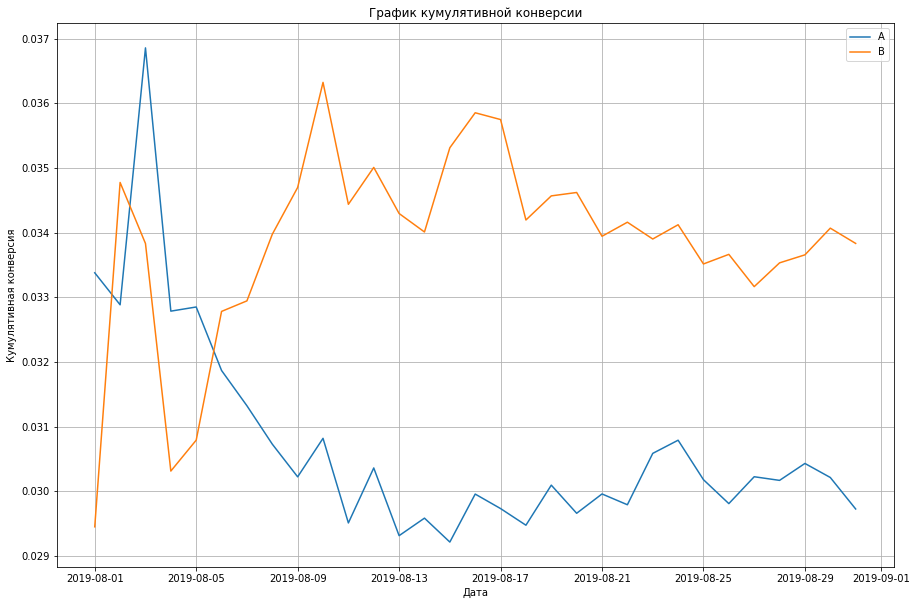

In [21]:
# строим графики

plt.figure(figsize=(15,10))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивной конверсии')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.grid()

С начала теста 2019-08-01 в среднем конверсия группы "А" была больше конверсии группы "В". Максимальный показатель конверсии группа "А" достигала 2019-08-03, затем началось резкое снижение кумулятивной конверсии и  2019-08-06 конверсия группы "В" стала больше конверсии группы "А". Конверсия группы "А" имела тренд к снижению примерно до 2019-08-10, затем произошла стабилизация и колебания дневной конверсии вошли в канал в районе 0,03.  Кумулятивная конверсия группы "В" начала увеличиваться 2019-08-04 и с этой даты вошла в тренд роста, максимального значения конверсия группы "В" достигла 2019-08-10, после этого конверсия пошла на снижение, но в среднем колебалась в одном канале в районе 0,034.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

In [22]:
# Объедините таблицы cumulativeDataA и cumulativeDataB методом

mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']], 
                                      left_on='date', 
                                      right_on='date', 
                                      how='left', 
                                      suffixes=['A', 'B'])
                              )

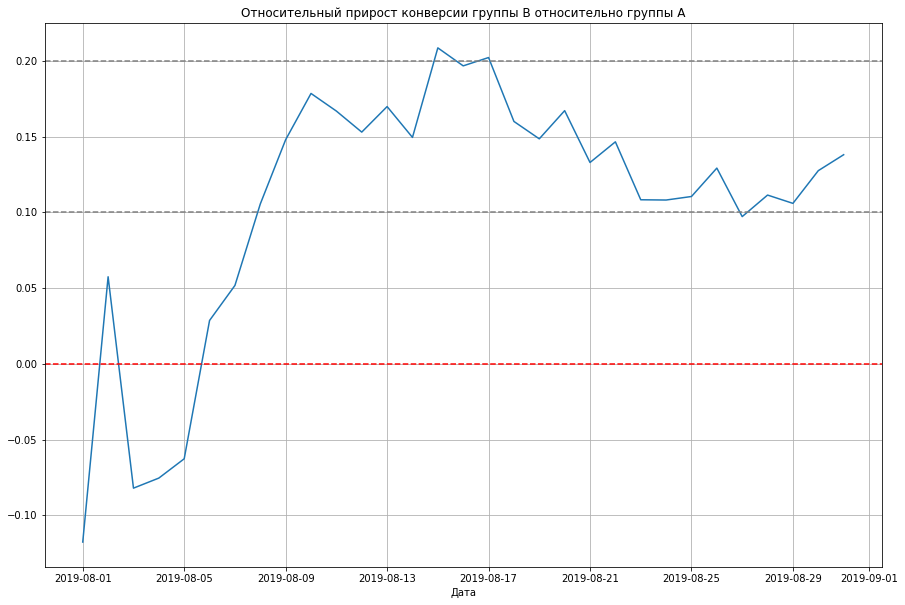

In [23]:
#строим график

plt.figure(figsize=(15,10))

plt.plot(mergedCumulativeConversions['date'], 
          mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)


plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')



plt.title("Относительный прирост конверсии группы B относительно группы A")
plt.xlabel('Дата')
plt.grid()

График относительного изменения кумулятивной конверсии группы B к группе A, более ярко раскрывает комментарии написаные выше. На нем мы можем так же наблюдать, что с начала теста конверсия группы В была ниже группы А, 2019-08-02 кумулятивная конверсия группы В на день превысила конверсию группы А. На следующий день конверсия группы А превысила конверсию группы В и вплоть до 2019-08-06 перобладала. Шестого августа начался резкий рост кумулятивной конверсии группы В до 10 августа, затем конверсия стабилизировалась и колебалась в определенном канале.

### Построим точечный график количества заказов по пользователям.

In [24]:
# сгрупируем заказы по пользователям ипосчитае количество заказов 
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders'] #переименуем

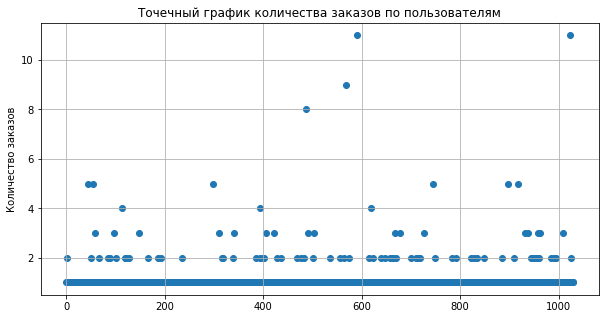

In [25]:
#построим точеченый график

x_values = pd.Series(range(0,len(ordersByUsers))) # серия из чисел от 0 до количества наблюдений в ordersByUsers

plt.figure(figsize=(10,5))

plt.scatter(x_values, ordersByUsers['orders']) 

plt.title("Точечный график количества заказов по пользователям")
plt.ylabel('Количество заказов')
plt.grid()

На точечном графике можно наблюдать, что большинство пользователей делают единичный заказ. Пользователей, которые делают два заказа значительно меньше, а количество тех кто совершают более 2-х заказов визуально крайне мало. Скорее всего, те кто совершают более 2-х заказов можно отправить в категорию "выбросов". Для того, чтобы более подробнее разобраться в это ситуации посчитаем перцентили ниже:

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

Посчитаем перцентели 95 и 9 для определения границы аномальных пользователей сделавших большое количесвто заказов:

In [26]:
percentile_95 = np.percentile(ordersByUsers['orders'], [95])
percentile_99 = np.percentile(ordersByUsers['orders'], [99])
display(f'95-й  перцентиль равен {percentile_95} заказам, а 99-й перцентиль равен {percentile_99} заказам')

'95-й  перцентиль равен [2.] заказам, а 99-й перцентиль равен [4.] заказам'

И так, после определения 95-ого и 99-ого перцентиля можно сказать:

1) Пять процентов пользователей делают более 2-х заказов

2) Четыре и более заказов делают только 1% пользователей.

При фильтрации данных будем отбрасывать значения количества заказов, кототрые превышают цифру 2.

### Построим точечный график стоимостей заказов

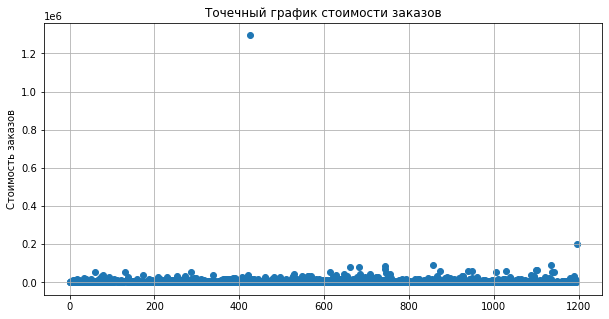

In [27]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(10,5))

plt.scatter(x_values, orders['revenue']) 

plt.title("Точечный график стоимости заказов")
plt.ylabel('Стоимость заказов')
plt.grid()

И так, на графике явно видны выбросы, присутствуют крупные суммы заказов более 1,2 миллиона и 200 000. Как раз эти значения сильно дестабилизировали графики комулятивной выручки, среднего чека и конверсии. Для того, чтобы более точно расчитать границу аномальной суммы заказов, перейдем у изучению перцентелев ниже.

### Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [28]:
percentile_95_orders = np.percentile(orders['revenue'], [95])
percentile_99_orders = np.percentile(orders['revenue'], [99])
display(f'95-й  перцентиль равен {percentile_95_orders} стоимости заказов, а 99-й перцентиль равен {percentile_99_orders} стоимости заказов')

'95-й  перцентиль равен [28000.] стоимости заказов, а 99-й перцентиль равен [58233.2] стоимости заказов'

И так, после определения 95-ого и 99-ого перцентиля можно сказать:

1) Пять процентов пользователей заказывают на сумму более 28000

2) Только один процент пользователей заказывают на сумму более 58233.2.

Решено при фильтрации данных отбрасывать заказы на сумму более 58233.2.

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [29]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]  #выделим пользователей группы А по дням
visitorsADaily.columns = ['date', 'visitorsPerDateA'] 

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg( #комулятивные пользователи группы А по дням
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']] #выделим пользователей группы В по дням
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(  #комулятивные пользователи группы В по дням
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#выделим заказы и сумму заказов в гурппе "А" по дня
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']] 
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(  #комулятивные заказы и сумма заказов в гурппе "А" по дням
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

#выделим заказы и сумму заказов в гурппе "В" по дням
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(  #комулятивные заказы и сумма заказов в гурппе "В" по дням
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]


#объединим полученные таблицы
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


Подготовим выборки для расчета статистической значимости тестом Манна-Уитни:

In [30]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [31]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули. 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
             pd.Series(
                 0, 
                 index=np.arange(
                     data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
                 ), 
                 name='orders'
             )
    ]
            ,axis=0)
          
          

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
                      pd.Series(
                          0, 
                          index=np.arange
                          (data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
                          ), 
                          name='orders'
                      )
    ]
                     ,axis=0)
          

Посчитаем статистическую значимость различия конверсии по результатам двух недель теста методом Манна-Уитни:


Нулевая гипотеза H0: Статистически значимых различий в конверсии между группами нет

Альтернативная гипотеза H1: Есть статистически значимых различий в конверсии между группами

Критический уровень статистической значимости alpha принмаем равным 0,05 или 5%

In [32]:
alpha = 0.05 
results = stats.mannwhitneyu(sampleA, sampleB)


print('Критический уровень статистической значимости alpha = 0.05')
print('p-значение: ', results.pvalue.round(5))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print()
print('Относительное различие между группами:' "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Критический уровень статистической значимости alpha = 0.05
p-значение:  0.01679
Отвергаем нулевую гипотезу: разница статистически значима

Относительное различие между группами:0.138


И так, так как значение p-value (0.01679) меньше критического уровня статистической значимости alpha (0.05), то мы отвергаем нулевую гипотезу и делаем вывод, что статистическая разница между конверсиями по группам А и В значима. Относительное различие между группами составляет 13,8%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [33]:
alpha = 0.05 
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('Критический уровень статистической значимости alpha = 0.05')
print('p-значение: ', results.pvalue.round(5))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print()
print('Относительное различие между группами:' 
      '{0:.3f}'.format(
          orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1)
     )

Критический уровень статистической значимости alpha = 0.05
p-значение:  0.72929
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительное различие между группами:0.259


Значение p-value (0.72929), что больше установленного критического уровня статистической значимости alpha = 0.05. В связи с этим, мы не можем отвергать нулевую гипотезу, вывод о различии в среднем чеке заказа между группами по «сырым» данным сделать нельзя.

### Посчитаем статистическую значимость различий в конверсиях между группами по «очищенным» данным

Для начала подготовимся, сделаем срезы. 
Выше  мы решили относить пользователей, кто совершил 3 и более заказов в аномалии, (выбросы). Так как 95-й перцентиль у нас равен 2-м, то есть оставшиеся 5% (3 и более заказов) мы относим к выбросам.
Так же поступим и с сумой заказов, 99-й перцентиль у нас равен 58233.2, то что больше этой суммы отнем к выбросу. Сделаем срезы и схраним их в переменные usersWithManyOrders (для заказов) и usersWithExpensiveOrders (для стоимости):

In [34]:
percentile_orders= orders['revenue'].quantile(0.99) #выбивающиеся сумме заказы
percentile_number_of_orders = ordersByUsers['orders'].quantile(0.95) #выбивающиеся по количеству заказов

In [35]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > percentile_number_of_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > percentile_number_of_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > percentile_orders]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)   #объединим выьивающиеся значения в одну таблицу

print('Количество выбивающихся значений равно', abnormalUsers.shape[0]) #количесвто выбивающихся значений


Количество выбивающихся значений равно 31


In [36]:
#Объявим переменные sampleAFiltered и sampleBFiltered.


sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Посчитаем статистическую значимость различия конверсии по "очищенным" данным по результатам двух недель теста методом Манна-Уитни:


Нулевая гипотеза H0: Статистически значимых различий в конверсии между группами нет

Альтернативная гипотеза H1: Есть статистически значимых различий в конверсии между группами

Критический уровень статистической значимости alpha принмаем равным 0,05 или 5%

In [37]:
alpha = 0.05 
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)


print('Критический уровень статистической значимости alpha = 0.05')
print('p-значение: ', results.pvalue.round(5))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print()
print('Относительное различие между группами:' "{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

Критический уровень статистической значимости alpha = 0.05
p-значение:  0.01007
Отвергаем нулевую гипотезу: разница статистически значима

Относительное различие между группами:0.174


Посчитав статистическую значимость различий в конверсиях между группами по «очищенным» данным можно сказать, что занчение p-value (0.01007) меньше установленного критического уровня alpha = 0.05. В связи с этим, мыотвергаем нулевую гипотезу - разница конверсий между группами по «очищенным» данным статистически значима. Относительное различие между гркппами составляет 17,4%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [38]:
alpha = 0.05 
results = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue']
        )


print('Критический уровень статистической значимости alpha = 0.05')
print('p-значение: ', results.pvalue.round(5))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print()
print('Относительное различие между группами:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Критический уровень статистической значимости alpha = 0.05
p-значение:  0.79772
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительное различие между группами: -0.020


Значение p-value (0.79772) значительно больше критического уровня статистической значимости alpha = 0.05. В связи с этим, мы не отвергаем нулевую гипотезу, вывод о различии в среднем чеке заказа между группами по «очищенным» данным сделать нельзя. Средний чек группы В после очистки данных от выбросов меньше чем у группы А на 2%. До очистки выбросов средний чек группы В был больше на 26%.

## Решение по результатам теста

После анализа А/В тестирования можно сказать:

*По "сырым" данным*

1) По сырым, неочищенным от выбросов, данным статистическая разница между конверсиями по группам А и В значима. Относительное различие между группами составляет 13,8%.  

2) Статистическая разница между группами по среднему чеку несущественная. Различия по среднему счеку между группами отсутствуют. Относительное различие между группами составляет  26%.

*По очищенным данным*

3) Разница конверсий между группами по «очищенным» данным статистически значима. Относительное различие между группами составляет 17,4%.

4)  Вывод о различии в среднем чеке заказа между группами по «очищенным» данным сделать нельзя. Средний чек группы В после очистки данных от выбросов меньше чем у группы А на 2%. До очистки выбросов средний чек группы В был больше на 26%, такое явное отличие было связано с аномально большими суммами заказов, которые были позднее отброшены.

**Вывод**

Результаты тестировани вполне однозначны. Конверсия у группы B увеличилась, хотя разница по среднему чеку не ощутима. Можно сказать, что эксперемент удался, группа В показывает себя лучше. Принимаем решение остановить тестирование.